# Non-rectangular RVE

This notebook includes some simple 2D examples of how to generate an RVE (Laguerre diagram) in a non-rectangular domain with grains of given areas. The non-rectangular domain is defined by a triangulation.

We use the optimal transport library [pysdot](https://github.com/sd-ot/pysdot) and the visualisation library [vtk](https://pypi.org/project/vtk/). The library pysdot implements the damped Newton algorithm from [here](https://arxiv.org/abs/1603.05579).

For an introduction to optimal transport theory applied to microstructure modelling see [here](https://www.tandfonline.com/doi/full/10.1080/14786435.2020.1790053).

In [1]:
# Install pysdot and vtk

RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !pip install pysdot > install_pysdot.log
    !pip install vtk > install_vtk.log

In [2]:
# Import libraries

import numpy as np
from scipy.spatial import Delaunay

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

from pysdot.domain_types import ConvexPolyhedraAssembly
from pysdot import OptimalTransport
from pysdot import PowerDiagram

# vtk
import vtk
from vtk.numpy_interface import dataset_adapter as dsa
from vtk.util.numpy_support import vtk_to_numpy

## 1. Non-periodic example

In this example we take the domain to be a triangulation of the region lying below the curve $y = 1 + 0.2 \sin (2 \pi x)$, $0 \le x \le 1$.

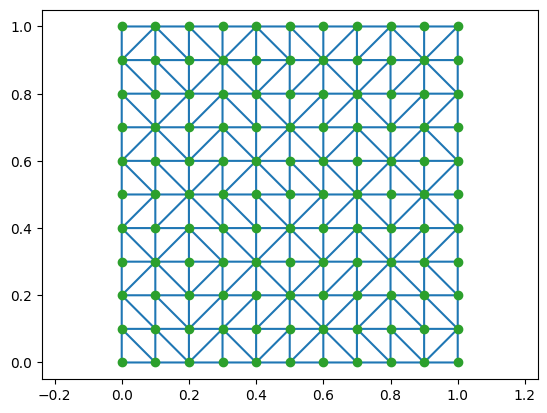

In [3]:
# First we create a triangulation of a square

Nx = 11
Ny = 11
x = np.linspace(0,1,Nx)
y = np.linspace(0,1,Ny)
X, Y = np.meshgrid(x,y)
points = np.array([X.flatten(),Y.flatten()]).T
tri = Delaunay(points)

# Plot the triangulation
fig, ax = plt.subplots()
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
ax.axis('equal')
plt.show()

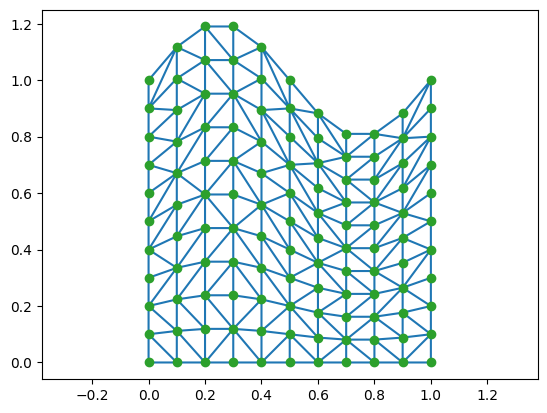

In [4]:
# Distort the triangulation to get a non-rectangular domain
X = np.linspace(0,1,Nx)
distorted_points = []
for x in X:
    y_max =  1 + 0.2*np.sin(2*np.pi*x)
    ys = np.linspace(0,y_max,Ny)
    for y in ys:
        distorted_points.append([x,y])

distorted_points = np.array(distorted_points)

# Plot the distorted triangulation
fig, ax = plt.subplots()
plt.triplot(distorted_points[:,0], distorted_points[:,1], tri.simplices)
plt.plot(distorted_points[:,0], distorted_points[:,1], 'o')
ax.axis('equal')
plt.show()

points = distorted_points

Now we build the RVE using the pysdot class `ConvexPolyhedraAssembly` and the method `add_simplex` to add each triangle in the triangulation one by one.

In [5]:
# Build the domain

om = ConvexPolyhedraAssembly() # Initialise the domain

numTri = np.shape(tri.simplices)[0] # number of triangles in the triangulation

# Add each triangle to the domain one by one
for k in range(numTri):

    T = tri.simplices[k] # indices of vertices in the triangle (ordered clockwise)
    p = points[T,:] # coordinates of vertices in the triangle
    om.add_simplex(p) # add the triangle to the domain

# Consistency check
print(om.measure()) # This should be 1

0.999999999999999


The following function is used for generating an RVE with grains of given areas (see for example Algorithm 1 [here](https://www.tandfonline.com/doi/full/10.1080/14786435.2020.1790053) and Algorithm 1 [here](https://arxiv.org/abs/1603.05579)).

In [6]:
def solve_OT_problem(x,v,om):
    """
    This function uses pysdot to solve the semi-discrete optimal transport
    problem with source measure equal to the Lebesgue measure on the domain om
    and target measure equal to \sum_i v_i \delta_{x_i}.

    Inputs:
        x  - seeds, (n,2) numpy array (assumed to lie inside the domain om)
        v  - areas, (n,) numpy array
        om - domain, pysdot ConvexPolyhedraAssembly

    Outputs:
        w - weights of the Laguerre diagram, (n,) numpy array
        areas - areas of the Laguerre cells, (n,) numpy array

    """

    n = np.shape(v) # number of seeds

    # Error tolerance for the OT solver
    err_tol = 1e-3*np.min(v)

    # Generate initial weights such that all cells have positive area
    w0 = np.zeros(n)

    # Initialise the optimal transport problem
    ot = OptimalTransport(positions = x, masses = v, weights = w0, domain = om,
                          obj_max_dm = err_tol, verbosity = 0,
                          linear_solver = 'Scipy')

    # Solve the optimal transport problem
    ot.adjust_weights()

    # Get cell data
    areas = ot.pd.integrals() # areas of the cells
    w = ot.get_weights() # weights

    # Difference between the true areas and target areas
    area_error = np.max( np.abs(v-areas) )

    # Error message if dv > tolerance
    if area_error > err_tol:
        print('Maximum error in area ',area_error)
        raise('Volume tolerance not met')

    return w, areas

Let's do a simple example where all the grains have equal area:

In [7]:
# Simple example with grains of equal area

n = 20 # number of grains
a = np.ones(n)*om.measure()/n # grains have equal area
x = np.random.rand(n,2)@np.diag([1,0.8]) # all seeds belong to om
w, areas = solve_OT_problem(x,a,om)

We can plot the Laguerre diagram using vtk:

In [8]:
# Function for plotting Laguerre tessellations and
# 1-periodic Laguerre tessellations (periodic in the x-direction)
def plot_cells(x,w,om,ax,periodic=False):

    pd = PowerDiagram(positions=x,weights=w,domain=om)

    tmpvtkfile = "tmp.vtk";
    pd.display_vtk(tmpvtkfile)

    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(tmpvtkfile)
    reader.Update()
    data = reader.GetOutput()

    N = data.GetNumberOfCells()

    numpy_array_of_cells = dsa.WrapDataObject(data).Cells
    numpy_array_of_points = dsa.WrapDataObject(data).Points
    numpy_array_of_nums = dsa.WrapDataObject(data).CellData['num']

    cells = vtk_to_numpy(numpy_array_of_cells)
    verts = vtk_to_numpy(numpy_array_of_points)
    nums = vtk_to_numpy(numpy_array_of_nums).astype(int)

    # Ncells is the number of Laguerre cells
    # (3 times the number of cells in the case of periodicity in the x-direction)
    Ncells=max(nums)+1
    if periodic:
        Ncells=Ncells/3

    # If periodic = True, then the index of each cell piece should be taken modulo Ncells
    nums = nums % Ncells

    # The color map is sampled at Ncells points
    cmap = mpl.colormaps['jet'].resampled(int(Ncells))

    idx = 0

    for k in range(N):
        nv = cells[idx]
        vidx = cells[idx+1:idx+nv+1]

        c=nums[k]/(Ncells-1)
        idx = idx+nv+1

        # Accumulate cell vertices
        ax.fill(verts[vidx,0],verts[vidx,1],linewidth=1,color=cmap(c))

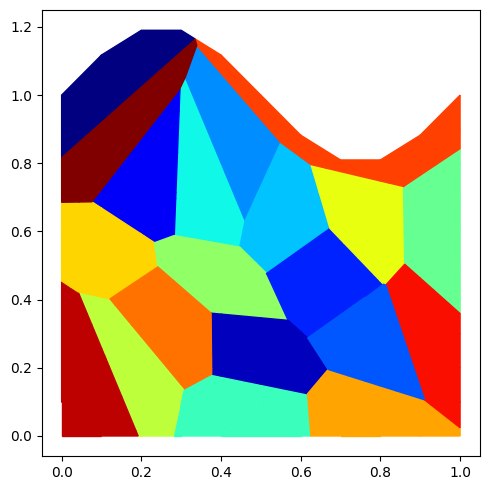

In [9]:
f, ax = plt.subplots(figsize=(5,5),layout='tight')
plot_cells(x,w,om,ax)

All the cells have equal area, up to a 0.1% tolerance.

We can generate a more regular RVE using Lloyd's algorithm (see for example Algorithm 2 [here](https://www.tandfonline.com/doi/full/10.1080/14786435.2020.1790053)):

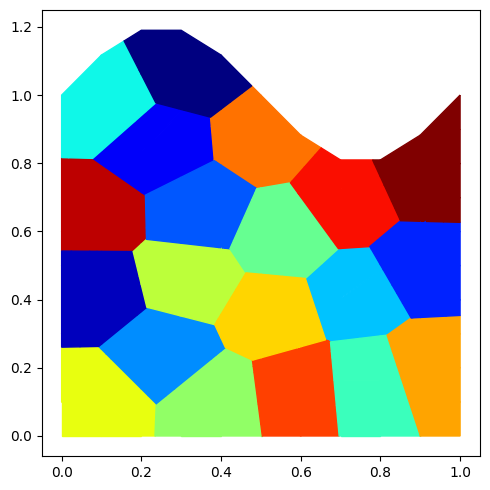

In [10]:
# Perform Lloyd's algorithm to get a more regular diagram

n = 20 # number of grains
a = np.ones(n)*om.measure()/n # grains have equal area
x = np.random.rand(n,2)@np.diag([1,0.8]) # initial position of the seeds
w, _ = solve_OT_problem(x,a,om)

numLloyd = 10 # number of Lloyd iterations
for _ in range(numLloyd):
    pd = PowerDiagram(positions=x,weights=w,domain=om)
    x = pd.centroids() # centroids of the cells
    w, _ = solve_OT_problem(x,a,om)

f, ax = plt.subplots(figsize=(5,5),layout='tight')
plot_cells(x,w,om,ax)

Again, all the cells have equal area, up to a 0.1% tolerance, but the cells are more regular.


## 2. Periodic example

In this example we take the domain to be a triangulation of the region lying below the curve $y = 1 + 0.2 \sin (2 \pi x)$, $0 \le x \le 1$, and
periodic in the $x$-direction.

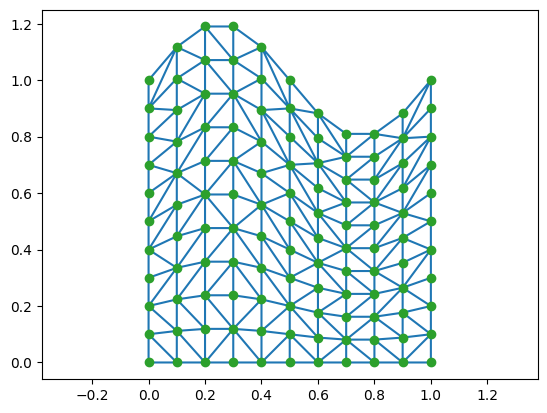

In [11]:
# First we create a triangulation of a square
Nx = 11
Ny = 11
Lx = 1 # width of the fundamental domain
x = np.linspace(0,Lx,Nx)
y = np.linspace(0,1,Ny)
X, Y = np.meshgrid(x,y)
points = np.array([X.flatten(),Y.flatten()]).T
tri = Delaunay(points)

# Now we distort the triangulation to get a non-rectangular domain
X = np.linspace(0,1,Nx)
distorted_points = []
for x in X:
    y_max =  1 + 0.2*np.sin(2*np.pi*x)
    ys = np.linspace(0,y_max,Ny)
    for y in ys:
        distorted_points.append([x,y])

distorted_points = np.array(distorted_points)

# Plot the distorted triangulation
fig, ax = plt.subplots()
plt.triplot(distorted_points[:,0], distorted_points[:,1], tri.simplices)
plt.plot(distorted_points[:,0], distorted_points[:,1], 'o')
ax.axis('equal')
plt.show()

points = distorted_points

Now we build the RVE using the pysdot class `ConvexPolyhedraAssembly` and the method `add_simplex` to add each triangle in the triangulation one by one. We also have to extend the triangulation by periodicity.

In [12]:
# Build the periodic domain

om = ConvexPolyhedraAssembly() # Initialise the domain

numTri = np.shape(tri.simplices)[0] # number of triangles in the triangulation

# Add each triangle to the domain one by one
for k in range(numTri):

    T = tri.simplices[k] # indices of vertices in the triangle (ordered clockwise)
    p = points[T,:] # coordinates of vertices in the triangle
    om.add_simplex(p) # add the triangle to the domain

    # Add a periodic copy on the left
    translation = [[Lx,0.],[Lx,0.],[Lx,0.]]
    om.add_simplex(p-translation)

    # Add a periodic copy on the right
    om.add_simplex(p+translation)

# Consistency check
print(om.measure()/3) # This should be 1

0.9999999999999992


The following function is used for generating a periodic RVE with grains of given areas (see for example Algorithm 1 [here](https://www.tandfonline.com/doi/full/10.1080/14786435.2020.1790053) and Algorithm 1 [here](https://arxiv.org/abs/1603.05579)).

In [13]:
def solve_OT_problem_periodicX(x,v,om,Lx):
    """
    This function uses pysdot to solve the semi-discrete optimal transport
    problem with source measure equal to the Lebesgue measure on the domain om
    and target measure equal to \sum_i v_i \delta_{x_i}. The domain is periodic
    in the x-direction.

    Inputs:
        x  - seeds, (n,2) numpy array (assumed to lie inside the domain om)
        v  - areas, (n,) numpy array
        om - domain, pysdot ConvexPolyhedraAssembly

    Outputs:
        w - weights of the Laguerre diagram, (n,) numpy array
        areas - areas of the Laguerre cells, (n,) numpy array

    """

    n = np.shape(v) # number of seeds

    # Error tolerance for the OT solver
    err_tol = 1e-3*np.min(v)

    # Generate initial weights such that all cells have positive area
    w0 = np.zeros(n)

    # Initialise the optimal transport problem
    ot = OptimalTransport(positions = x, masses = v, weights = w0, domain = om,
                          obj_max_dm = err_tol, verbosity = 0,
                          linear_solver = 'Scipy')

    # Make the Laguerre diagram periodic in the x-direction
    ot.pd.add_replication(Lx*[1,0])
    ot.pd.add_replication(Lx*[-1,0])

    # Solve the optimal transport problem
    ot.adjust_weights()

    # Get cell data
    areas = ot.pd.integrals() # areas of the cells
    w = ot.get_weights() # weights

    return w, areas

A simple example with grains of equal area:

In [14]:
# Simple example with grains of equal area

n = 20 # number of grains
a = np.ones(n)*(om.measure()/3)/n # grains have equal area
x = np.random.rand(n,2)@np.diag([1,0.8]) # all seeds belong to the fundamental region
w, areas = solve_OT_problem_periodicX(x,a,om,Lx)

# Consistency check
print(np.sum(areas)) # this should be 1

1.0


Plot the periodic RVE:

(0.0, 1.0)

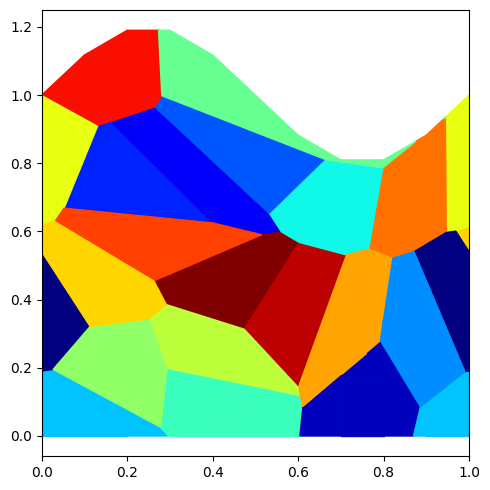

In [15]:
# Make periodic copies of the seeds
X = np.vstack((x,x,x))
for k in range(n):
    X[k,0] = X[k,0]-Lx
    X[2*n+k,0] = X[2*n+k,0]+Lx

# Make periodic copies of the weights
W = np.hstack((w,w,w))

f, ax = plt.subplots(figsize=(5,5),layout='tight')
plot_cells(X,W,om,ax,periodic=True)
ax.set_xlim([0, Lx])

The periodicity is evident from the colour of the grains. All the cells have equal area, up to a 0.1% tolerance

We can generate a more regular RVE using Lloyd's algorithm (see for example Algorithm 2 [here](https://www.tandfonline.com/doi/full/10.1080/14786435.2020.1790053)):

(0.0, 1.0)

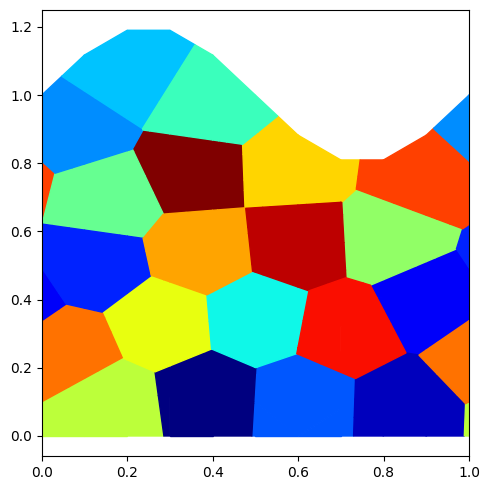

In [16]:
# Perform Lloyd's algorithm to get a more regular diagram

n = 20 # number of grains
a = np.ones(n)*(om.measure()/3)/n # grains have equal area
x = np.random.rand(n,2)@np.diag([1,0.8]) # all seeds belong to the fundamental region
w, _ = solve_OT_problem_periodicX(x,a,om,Lx)

numLloyd = 10 # number of Lloyd iterations
for _ in range(numLloyd):

    # Make periodic copies of the seeds
    X = np.vstack((x,x,x))
    for k in range(n):
        X[k,0] = X[k,0]-Lx
        X[2*n+k,0] = X[2*n+k,0]+Lx

    # Make periodic copies of the weights
    W = np.hstack((w,w,w))
    pd = PowerDiagram(positions=X,weights=W,domain=om)
    X = pd.centroids() # centroids of the cells
    x = X[n:2*n,:] # extract the centroids in the fundamental domain
    w, _ = solve_OT_problem_periodicX(x,a,om,Lx)

# Plot the RVE

# Make periodic copies of the seeds
X = np.vstack((x,x,x))
for k in range(n):
    X[k,0] = X[k,0]-Lx
    X[2*n+k,0] = X[2*n+k,0]+Lx

# Make periodic copies of the weights
W = np.hstack((w,w,w))

f, ax = plt.subplots(figsize=(5,5),layout='tight')
plot_cells(X,W,om,ax,periodic=True)
ax.set_xlim([0, Lx])

Again, all the cells have equal area, up to a 0.1% tolerance, but the cells are more regular. The periodicity is evident from the colour of the grains.